### Feature Engineering--True and False News
The final step of feature engineering is to tokenize the text of the stories.  The raw data sequence of characters cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.

I considered doing this using discrete Scikit-Learn modules, but the recently Tensorflow 2.1 adds support for a TextVectorization layer, and 2.3 adds experiment support for the new Keras Preprocessing Layers API. These layers allow you to package preprocessing logic inside the model for easier deployment — allowing the model to take raw strings, images, or rows from a table as input.  This module also includes a 

The processing of each sample contains the following steps:

1. Standardize each sample.  Lowercase all words and strip punctuation. 

2. Split each sample into substrings (usually words).

3. Recombine substrings into tokens (usually ngrams). Options here include determining how many words to include in each token.  Text classification tasks typically  consider tokens of 1 or 2 works, but we may experiment with more than that.

4. Index tokens (associate a unique int value with each token).

5. Transform each sample using this index, either into a vector of ints or a dense float vector.  This layer includes the ability to set the length of the resulting vector, either truncating or padding the vector with zeroes so it will fit the size of our input layer.  It also has several output modes, including tf-idf which is weighting algorithm based on the frequency of words found on the dataset.

From the Scikit-learn documentation: 
> The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.  In a large text corpus, some words will be very present (e.g. “the”, “a”, “is” in English) hence carrying very little meaningful information about the actual contents of the document. If we were to feed the direct count data directly to a classifier those very frequent terms would shadow the frequencies of rarer yet more interesting terms.
In order to re-weight the count features into floating point values suitable for usage by a classifier it is very common to use the tf–idf transform.

We will consider varying output modes as we go forward. 

Since the TextVectorization layer will allow us to convert the text of our stories to integer tensors, so there is not much for us to do with feature engineering.  

## Vocabulary Size
The default TextVectorization settings will retain all words found as part of our vocabulary.  In experimenting, we found some value in altering the vocabulary size.  

Below is the code we used to count words and find words that only appeared once, with the hypothesis that any word that appeared in only one article could not inform decisions on any other articles. The code and some further discussion is found below. 

In [1]:
!pip install --upgrade numpy
!pip install --upgrade pandas

# we want tensorflow 2.3
!pip install --upgrade tensorflow  

     |████████████████████████████████| 14.5MB 7.7MB/s eta 0:00:01
ERROR: tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
ERROR: autoai-libs 1.10.5 has requirement pandas>=0.24.2, but you'll have pandas 0.24.1 which is incompatible.
  Found existing installation: numpy 1.15.4
    Uninstalling numpy-1.15.4:
      Successfully uninstalled numpy-1.15.4
     |████████████████████████████████| 10.5MB 7.6MB/s eta 0:00:01
  Found existing installation: pandas 0.24.1
    Uninstalling pandas-0.24.1:
      Successfully uninstalled pandas-0.24.1
     |████████████████████████████████| 320.4MB 91kB/s s eta 0:00:01    |██▋                             | 25.8MB 27.5MB/s eta 0:00:11     |███████▋                        | 76.5MB 39.8MB/s eta 0:00:07     |████████▍                       | 84.4MB 39.8MB/s eta 0:00:06     |█████████                       | 90.6MB 39.8MB/s eta 0:00:06     |██████████████▎                 | 142.8MB 39.8MB/s eta 0:00:05     |████████████████▌ 

     |████████████████████████████████| 51kB 18.2MB/s eta 0:00:01
     |████████████████████████████████| 163kB 37.0MB/s eta 0:00:01
     |████████████████████████████████| 153kB 33.3MB/s eta 0:00:01
     |████████████████████████████████| 81kB 20.6MB/s eta 0:00:01
ERROR: tensorboard 2.3.0 has requirement grpcio>=1.24.3, but you'll have grpcio 1.16.1 which is incompatible.
  Found existing installation: numpy 1.19.1
    Uninstalling numpy-1.19.1:
      Successfully uninstalled numpy-1.19.1
  Found existing installation: scipy 1.2.0
    Uninstalling scipy-1.2.0:
      Successfully uninstalled scipy-1.2.0
  Found existing installation: tensorflow-estimator 1.13.0
    Uninstalling tensorflow-estimator-1.13.0:
      Successfully uninstalled tensorflow-estimator-1.13.0
  Found existing installation: setuptools 40.8.0
    Uninstalling setuptools-40.8.0:
      Successfully uninstalled setuptools-40.8.0
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully u

In [2]:
import tensorflow as tf
print("Tensorflow version: ", tf.__version__)
if not tf.__version__ == '2.3.0':
    raise ValueError('please upgrade to TensorFlow 2.3, or restart your Kernel (Kernel->Restart & Clear Output)')

Tensorflow version:  2.3.0


In [3]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
from time import time
import logging
import numpy as np
import pandas as pd
import string
import re

from keras.utils import to_categorical
from keras import models
from keras import layers

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.model_selection import train_test_split

from ibm_botocore.client import Config
import ibm_boto3

Using TensorFlow backend.


In [4]:
#Get our data
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_news = {
    'IAM_SERVICE_ID': 'iam-ServiceId-32e8ee67-397c-4ff1-b69b-543172331f43',
    'IBM_API_KEY_ID': 'Rx4FR4JSAueCnnIsoevsgYgOsuh8LCXtbkFpFpC0EmVU',
    'ENDPOINT': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'advanceddatasciencecapstone-donotdelete-pr-tqabpnbxebk8rm',
    'FILE': 'dfTrueFalseNews.pkl'
}

def download_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.download_file(Bucket=credentials['BUCKET'],Key=key,Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Downloaded')

def upload_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.upload_file(Filename=local_file_name, Bucket=credentials['BUCKET'],Key=key)
    except Exception as e:
        print(Exception, e)
    else:
        print(' File Uploaded')
        
dfNews = download_file_cos(credentials_news, "dfTrueFalseNews.pkl", "dfTrueFalseNews.pkl")

File Downloaded


In [5]:
dfNews = pd.read_pickle('dfTrueFalseNews.pkl')
#dfNews['truthvalue'] = pd.Categorical(dfNews['truthvalue'])

print (dfNews.shape, dfNews.columns, '\n',  dfNews.dtypes)

(1126, 3) Index(['text', 'source', 'truthvalue'], dtype='object') 
 text          object
source        object
truthvalue    object
dtype: object


In [6]:
dfNews.head()

,text,source,truthvalue
tech003legit,A Google computer victorious over the world's ...,MihalceaNewsLegit,1
polit11legit,White House keeps up sanctuary cities pressure...,MihalceaNewsLegit,1
biz40legit,Why Silicon Valley isn't fighting to save the ...,MihalceaNewsLegit,1
edu10legit,Protesters Disrupt DeVos School Visit Protes...,MihalceaNewsLegit,1
tech038legit,Solar-powered 'skin' could make prosthetics mo...,MihalceaNewsLegit,1


In [26]:
indexes = dfNews.index.values
x = dfNews['text'].values
y = dfNews['truthvalue'].values
print(type(x), type(y), indexes[0:2])

<class 'numpy.ndarray'> <class 'numpy.ndarray'> ['tech003legit' 'polit11legit']


In [8]:
X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

# Once we have our handles, we format the datasets in a Keras-fit compatible
# format: a tuple of the form (text_data, label).
def format_dataset(x, y):
  return (x, y)

train_dataset = list(map(format_dataset, X_train, y_train))
test_dataset = list(map(format_dataset, X_test, y_test))

# We also create a dataset with only the textual data in it. This will be used
# to build our vocabulary later on.
textL_dataset = list(map(lambda a:a, x))


In [9]:
print (len(X_train), len(X_test), len(y_train), len(y_test), len(textL_dataset), '\n',
type(X_train), type(X_test), type(y_train), type(y_test), type(textL_dataset))


900 226 900 226 1126 
 <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'>


In [10]:
# move our numpy structures into Tensorflow datasets
Dataset = tf.data.Dataset
text_dataset = tf.data.Dataset.from_tensor_slices(textL_dataset)

features_dataset = Dataset.from_tensor_slices(X_train)
labels_dataset = Dataset.from_tensor_slices(list(y_train))
tfds_train = Dataset.zip((features_dataset, labels_dataset))

features_test_dataset = Dataset.from_tensor_slices(X_test)
labels_test_dataset = Dataset.from_tensor_slices(list(y_test))
tfds_test = Dataset.zip((features_test_dataset, labels_test_dataset))

# Determine the optimum vocabulary size.  
The results for model 2 below showed that varying the vocabulary size was productive, with the optimum size seeming to be between 18000 and 25000.
We know there are a lot of junk words in our data, where spaces are missing and words appear only once in a story (ex: we find "dyma davi d la pajti" in our text, a French tranliteration of "Dumas Davy de la Pailleterie"). 

Let's count our words and see what the vocabulary size would be if we removed these.

Average story length: 328.6305506216696 Minimum story length: 27 Maximum story length: 14722 Standard deviation: 624.980898772334 Total words in corpus: 370038 Vocab size: 26595 Maxstoryrow: celeb060legit Minstoryrow: celeb131fake


(array([552., 248., 168.,  57.,  33.,  16.,   6.,  11.,   3.,   6.,   4.,
          4.,   1.,   2.,   1.,   1.,   2.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   1.,   2.,   1.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([   27.  ,   173.95,   320.9 ,   467.85,   614.8 ,   761.75,
          908.7 ,  1055.65,  1202.6 ,  1349.55,  1496.5 ,  1643.45,
         1790.4 ,  1937.35,  2084.3 ,  2231.25,  2378.2 ,  2525.15,
         2672.1 ,  2819.05,  2966.  ,  3112.95,  3259.9 ,  3406.85,
         3553.8 ,  3700.75,  3847.7 ,  3994.65

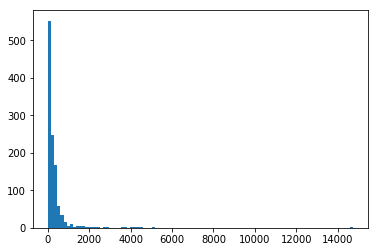

In [28]:
import re
import string
import statistics
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter
def CleanUpPunctuation(pattern, rep, input_data):
  lowercase = input_data.lower()
  s = pattern.sub(lambda m: rep[re.escape(m.group(0))], lowercase)
  return s


#rep = {"condition1": "", "condition2": "text"} # define desired replacements here
rep =  {re.escape(s):"" for i,s in enumerate(string.punctuation)}
# use these three lines to do the replacement
pattern = re.compile("|".join(rep.keys()))

v = list(x)
cnt = Counter()
storylength = []
unique = []
vocab = set()
row = 0
for a in v:
    u = set()
    a = CleanUpPunctuation(pattern, rep, a)
    # split returns a list of words delimited by sequences of whitespace (including tabs, newlines, etc, like re's \s) 
    alist = a.split()
    storylen = len(alist)
    storylength.append(storylen)
    if storylen == 14722:
        maxlenrow = row
    if storylen == 27:
        minlenrow = row
    u = u.union((alist))
    vocab = vocab.union(alist)
    unique.append (len(u))
    for word in alist:
        cnt[word] += 1
    row +=1
print ("Average story length: {} Minimum story length: {} Maximum story length: {} Standard deviation: {} Total words in corpus: {} Vocab size: {} Maxstoryrow: {} Minstoryrow: {}" \
       .format(statistics.mean(storylength), min(storylength), max(storylength), statistics.stdev(storylength), sum(storylength), len(vocab), indexes[maxlenrow], indexes[minlenrow]))
plt.hist(storylength, 100)

In [12]:
# we have 26595 unique words in our vocabulary
len(cnt)

26595

In [22]:
cnt.most_common()[-5:-1]

[('crosses', 1), ('biology', 1), ('growsandstates', 1), ('indianas', 1)]

In [23]:
# we have 11,910 words that only appear once in any article.
# 26,595 - 11,910 = 14685
cntd = dict(cnt)
sort_orders = sorted(cntd.items(), key=lambda x: x[1], reverse=False)
singles = []
for i in sort_orders:
    if i[1] ==1:
        singles.append(i[0])
len(singles)

11910

### Vocabulary Size
Of the 26,595 words in our articles, we have 11,910 words used once, leaving 14,685 words found in more than one article.  Any analysis that depends on finding the same word multiple articles will not find any of these 11,910 words, so from that standpoint they are just noise.  However, embeddings that rely on analysis broader than word or ngram repetition, such as sentence structure, or by inferring parts of speech, will likely find meaning in words that appear once, so we will keep or remove them based on the vectorization we are using. 

#### (Below is just kept as a note to myself on how to find a record based on its key value.)

In [15]:
i = dfNews.index.get_loc('biz01legit')
print (i)
#dfNews.iloc[i:i+2]
dfNews['text'][159]



159


'Alex Jones Apologizes for Promoting \'Pizzagate\' Hoax  Alex Jones  a prominent conspiracy theorist and the host of a popular right-wing radio show  has apologized for helping to spread and promote the hoax known as Pizzagate. The admission on Friday by Mr. Jones  the host of "The Alex Jones Show" and the operator of the website Infowars  was striking. In addition to promoting the Pizzagate conspiracy theory  he has contended that the Sept. 11 attacks were inside jobs carried out by the United States government and that the 2012 shooting at Sandy Hook Elementary School in Newtown  Conn.  was a hoax concocted by those hostile to the Second Amendment. The Pizzagate theory  which posited with no evidence that top Democratic officials were involved with a satanic child pornography ring centered around Comet Ping Pong  a pizza restaurant in Washington  D.C.  grew in online forums before making its way to more visible venues  including Mr. Jones\'s show. And its prominence after the electio